<a href="https://colab.research.google.com/github/kumarpreetilata/Unsupervised_PCA_Based_Anomaly_Detection/blob/main/Unsupervised_PCA_Based_Anomaly_Detection_to_predict_failures_in_rotating_machinery_dataset_by_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Unsupervised PCA- Based Anomaly Detection to predict failures in rotating machinery dataset by NASA**

The project uses NASA dataset of four bearings to predict failures of the rotating machinery. The dataset contains vibration data of four bearings supporting a rotating shaft with a radial load of 6000 pounds applied to it. The bearing were run to failure and vibration data was captured by high-sensitivity quartz accelerometer at regular intervals of 10 minutes apart until faiure occured. The dataset is the culled version of original data and contains 984 samples. PCA based anomaly detection is used to build a model to recognize/alarm of increased vibartion in any bearing, as an early sign of impending failure.

```
# This is formatted as code
```



In [ ]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['bearings.csv']), index_col=0, parse_dates= [0])# Dataset is now stored in a Pandas Dataframe
df.head()

Saving bearings.csv to bearings (4).csv


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [ ]:
df.shape

(984, 4)

In [ ]:
df.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 984 entries, 2004-02-12 10:32:39 to 2004-02-19 06:22:39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing 1  984 non-null    float64
 1   Bearing 2  984 non-null    float64
 2   Bearing 3  984 non-null    float64
 3   Bearing 4  984 non-null    float64
dtypes: float64(4)
memory usage: 38.4 KB


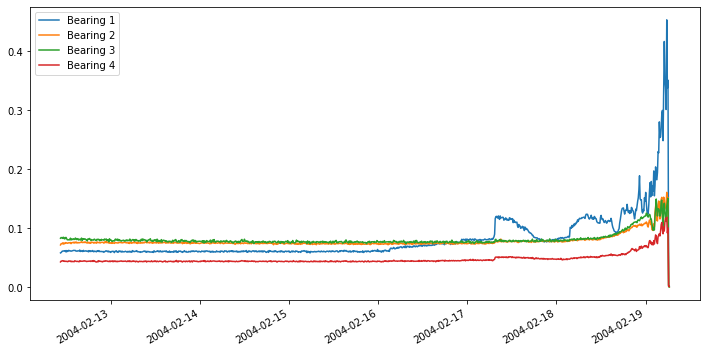

In [ ]:
df.plot(figsize=(12,6))

The graph show that approx. after 4 days, vibration starts increasing. The nesxt day there is again a spike and the following day, failure occurs.
Lets now apply pca to transform and reduce the dimension of df to 1 component.

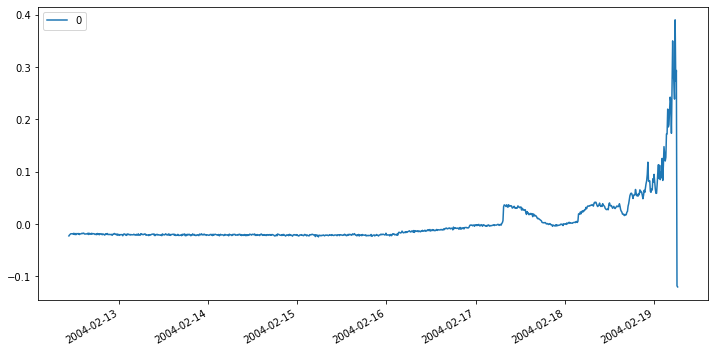

In [ ]:
pca= PCA (n_components =1, random_state=0)
df_pca = pd.DataFrame(pca.fit_transform(df))
df_pca.index= df.index
df_pca.plot( figsize = (12,6))


The pca plot still shows the spike as close as original, despite some loss of information.
Now we will inverse transform to get a df a close to original df to see the loss. And then calc error between original and restored df.

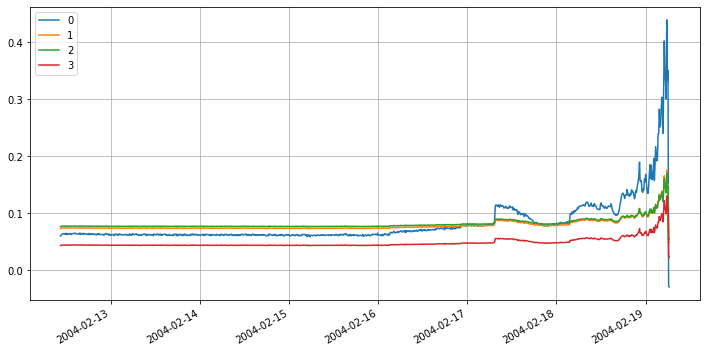

In [ ]:
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index= df_pca.index)

df_restored.plot(figsize = (12,6)).grid()

## Defining error function.

In [ ]:
def anomaly_scores(df_original, df_restored):
   loss = np.sum((np.array(df_original)-np.array(df_restored))**2,axis=1)
   loss = pd.Series(data=loss, index = df_original.index)
   return loss

scores = anomaly_scores(df, df_restored)
scores



2004-02-12 10:32:39    0.000053
2004-02-12 10:42:39    0.000070
2004-02-12 10:52:39    0.000057
2004-02-12 11:02:39    0.000060
2004-02-12 11:12:39    0.000043
                         ...   
2004-02-19 05:42:39    0.001558
2004-02-19 05:52:39    0.000411
2004-02-19 06:02:39    0.000094
2004-02-19 06:12:39    0.005981
2004-02-19 06:22:39    0.006526
Length: 984, dtype: float64

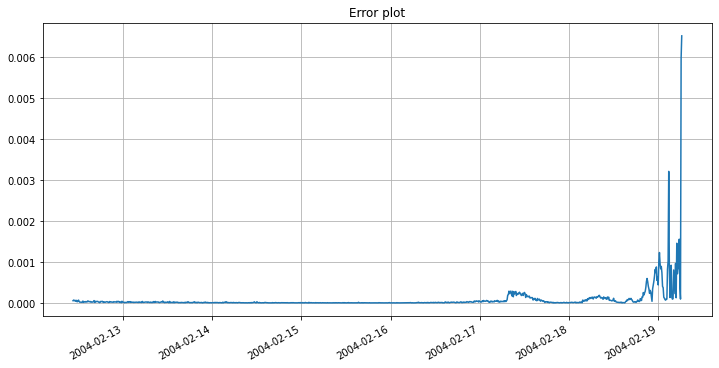

In [ ]:
scores.plot(figsize = (12,6), title = 'Error plot').grid()

We can see that the error is clearly visible at somehwhere before 0.00001. 
Adjusting at 0.000059 is quite a good number, as this covers almost al the errors and alerts 2.5 days before failure.
Initial error is insignificant as the machine may vibrate quite heavily during start.

Defining prediction model/ Alert model

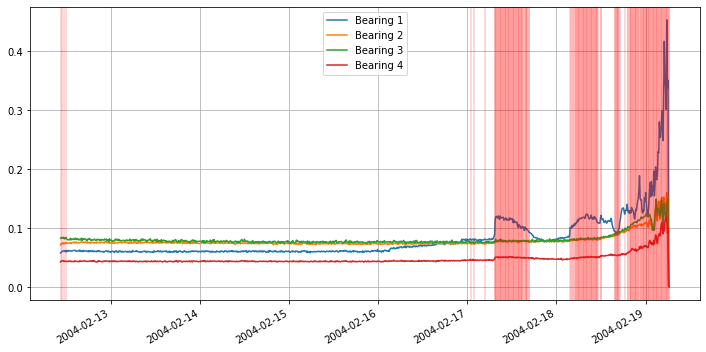

In [ ]:
def is_anomaly(data, pca, threshold):
  pca_data = pca.transform(data)
  restored_data = pca.inverse_transform(pca_data)
  loss=np.sum((data-restored_data)**2)
  return loss > threshold


df.plot(figsize = (12,6))
for index, row in df.iterrows():
  if is_anomaly([row], pca, 0.000059):
    plt.axvline(row.name, color = 'r', alpha=0.2)
    plt.grid()